In [0]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# !pip3 install -U torch torchvision
import torch
cuda=torch.cuda.is_available()
torch.__version__, cuda

('1.1.0', False)

In [0]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

# MNIST w/ torch

https://github.com/udacity/deep-learning-v2-pytorch/tree/master/autoencoder

In [0]:
import torch

num_workers = 0  # number of subprocesses to use for data loading
batch_size = 20  # how many samples per batch to load
imgsize = 28
epochs = 20
patience = 2  #early stopping

## Load Data

In [0]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
    
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

print(len(train_data))

60000


In [0]:
#visualize
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## Linear Autoencoder

Inputs=outputs=28x28 length vectors. The encoder and decoder will be made of two linear layers, each. The depth dimensions should change as follows: 784 inputs > encoding_dim > 784 outputs. All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,encoding_dim):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(28*28, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, 28*28)        

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = Autoencoder(encoding_dim=32)
print(model)

criterion = nn.MSELoss()  # Prob output with MSELoss
optimizer = torch.optim.Adam(model.parameters())

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


In [0]:
images, labels = next(iter(train_loader))
print(images.shape)
print(model(images).shape)

torch.Size([20, 1, 28, 28])
torch.Size([20, 784])


### Train

In [0]:
if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = 0.
    
    for data, _ in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        data = data.view(data.size(0), -1)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)        # autoencoder: target=input
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

### Evaluate

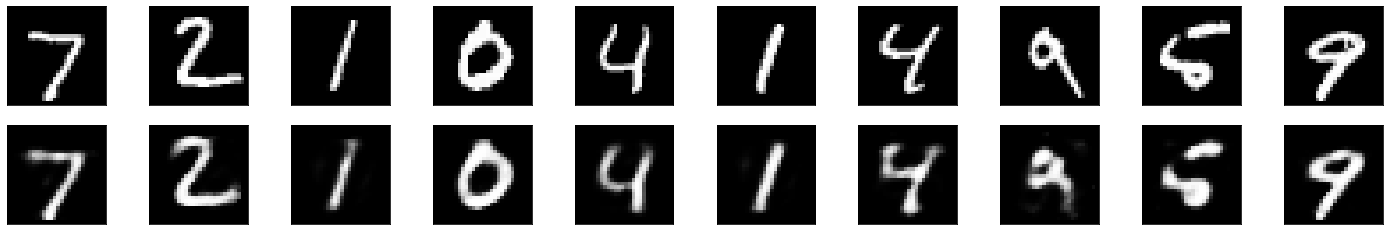

In [0]:
images, _ = next(iter(test_loader))
output = model(images.view(images.size(0), -1)).view(batch_size, 1, 28, 28)
output = output.detach()# detach output from requires_grad so that it can be converted to numpy

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Convolutional Autoencoder

* encoder: typical CNN with maxpooling
* decoder: needs to upsample:
 * uses **transposed convolutional layers** `nn.ConvTranspose2d`. Avoid checkerboard patterns by setting `stride=kernel_size`, or
 * use `F.interpolate` and normal `Conv2d` to increase width and height

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder ##
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # depth grows 1 -> 16
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)  # depth shrinks 16 -> 4
        self.pool = nn.MaxPool2d(2, 2)
        
        ## for decoder choice 1 ##
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2) # depth grows 4 -> 16, kernelsize=stride
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2) # depth shrinks 16 -> 1                
        ## for decoder choice 2 ##
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        ## encode/inference ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)             # size halved
        x = F.relu(self.conv2(x))
        x = self.pool(x)             # size halved
        
        ## decode/generation choice 1 ##
#         x = F.relu(self.t_conv1(x))     # size doubled 
#         x = F.sigmoid(self.t_conv2(x))  # size doubled 
        
        ## decode/generation choice 2 ##
        x = F.interpolate(x, scale_factor=2, mode='nearest') # size doubled 
        x = F.relu(self.conv4(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest') # size doubled 
        x = F.sigmoid(self.conv5(x))
                
        return x

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [0]:
if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = 0.
    
    for data, _ in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)        # autoencoder: target=input
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

### Evaluate

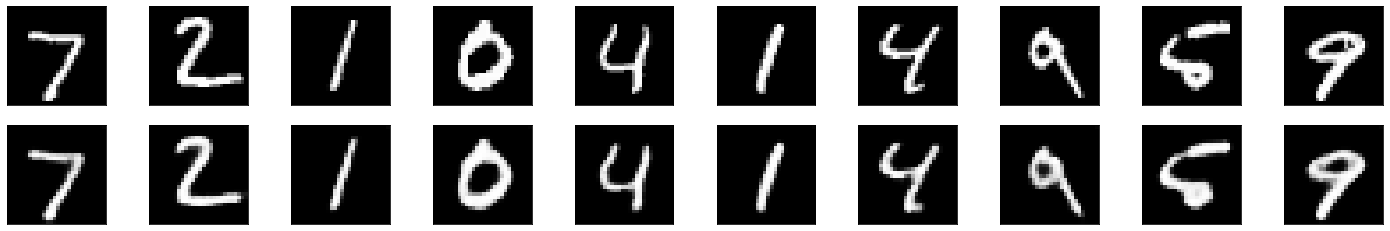

In [0]:
images, _ = next(iter(test_loader))
output = model(images)
output = output.detach()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Denoising Convolutional Autoencoder

use noisy images as input and the original, clean images as targets.

use deeper convolutional layers here; layers with more feature maps

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)# one conv layer to decrease the depth


    def forward(self, x):
        ## encode ##
        x = self.pool(F.relu(self.conv1(x)))# size halved
        x = self.pool(F.relu(self.conv2(x)))# size halved
        x = self.pool(F.relu(self.conv3(x)))# size halved
        
        ## decode ##
        x = F.relu(self.t_conv1(x))  # size doubled
        x = F.relu(self.t_conv2(x))  # size doubled
        x = F.relu(self.t_conv3(x))  # size doubled
        x = F.sigmoid(self.conv_out(x))
                
        return x

model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [0]:
noise = 0.5 # noisy scale

In [0]:
if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = 0.
    
    for data, _ in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        noisy_imgs = data + noise * torch.randn(*data.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)

        optimizer.zero_grad()
        output = model(noisy_imgs)
        loss = criterion(output, data)        # autoencoder: target=input
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader)

    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

### Evaluate

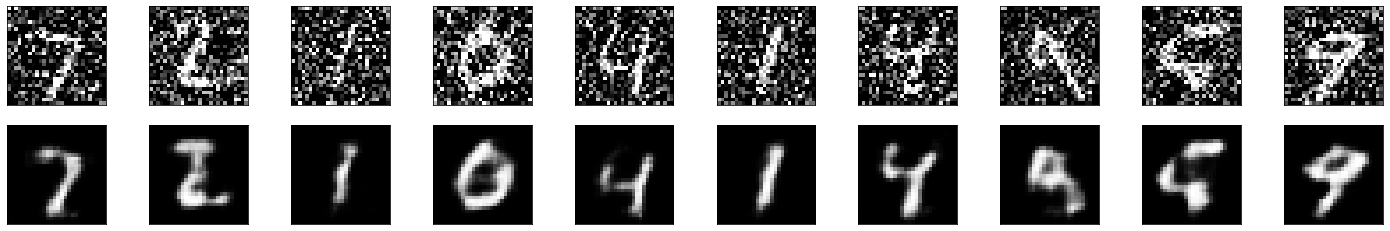

In [0]:
images, _ = next(iter(test_loader))
noisy_imgs = images + noise * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

output = model(noisy_imgs)
output = output.detach()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# MNIST w/ tensorflow/keras
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://www.tensorflow.org/alpha/tutorials/generative/cvae

In [1]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# Normalize
x_train /= 255.
x_test /= 255.

# Binarize
x_train[x_train >= .5] = 1.
x_train[x_train < .5] = 0.
x_test[x_test >= .5] = 1.
x_test[x_test < .5] = 0.

print(x_train.shape)
x_train_flat = x_train.reshape(x_train.shape[0],-1)  # for mlp
x_test_flat = x_test.reshape(x_test.shape[0],-1)  # for mlp

11493376/11490434 [==============================] - 3s 0us/step
(60000, 28, 28, 1)


## Models

In [24]:
######################## mlp ########################
encoding_dim = 32
x = tf.keras.layers.Input(shape=(28**2,))
y = tf.keras.layers.Flatten()(x)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
y = tf.keras.layers.Dense(32, activation='relu')(y)

z = tf.keras.layers.Dense(64, activation='relu')(y)
z = tf.keras.layers.Dense(128, activation='relu')(z)
z = tf.keras.layers.Dense(28**2, activation='sigmoid')(z)

mlp = tf.keras.models.Model(x, z)
mlp.compile(optimizer='adadelta', loss='binary_crossentropy')

In [25]:
######################## conv ########################
x = tf.keras.layers.Input(shape=(28, 28, 1))

z = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)  # (28, 28, 16)
z = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(z)                   # (14, 14, 16)
z = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(z)   # (14, 14, 8)
z = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(z)                   # (7, 7, 8)
z = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(z)   # (7, 7, 8)
z = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(z)                   # (4, 4, 8)

# y = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(z)   # (4, 4, 8)
# y = tf.keras.layers.UpSampling2D((2, 2))(y)                                   # (8, 8, 8)
# y = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(y)   # (8, 8, 8)
# y = tf.keras.layers.UpSampling2D((2, 2))(y)                                   # (16, 16, 8)
# y = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(y)                  # (14, 14, 16), <- no padding
# y = tf.keras.layers.UpSampling2D((2, 2))(y)                                   # (28, 28, 16) 
# y = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)# (28, 28, 1) 

y = tf.keras.layers.Conv2DTranspose(8,  3, strides=2, activation='relu', padding='same')(z) # (8, 8, 8)
y = tf.keras.layers.Conv2D         (8,  2, strides=1, activation='relu')(y)                 # (7, 7, 8)
y = tf.keras.layers.Conv2DTranspose(8,  3, strides=2, activation='relu', padding='same')(y) # (14, 14, 8)
y = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same')(y) # (28, 28, 16)
y = tf.keras.layers.Conv2DTranspose(1,  3, strides=1, activation='sigmoid', padding='same')(y)

conv = tf.keras.models.Model(x, y)
conv.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
###################### conv denoiser #######################
x = tf.keras.layers.Input(shape=(28, 28, 1))

z = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # (28, 28, 16)
z = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(z)                   # (14, 14, 16)
z = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(z)  # (14, 14, 8)
z = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(z)                   # (7, 7, 32)

# y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(z)  # (7, 7, 32)   #using UpSampling2D, 28,353 params
# y = tf.keras.layers.UpSampling2D((2, 2))(y)                                   # (14, 14, 32)
# y = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(y)  # (14, 14, 32)
# y = tf.keras.layers.UpSampling2D((2, 2))(y)                                   # (28, 28, 32)
# y = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)# (28, 28, 1)

y = tf.keras.layers.Conv2DTranspose(32, (3, 3), 1, activation='relu', padding='same')(z)    # (7, 7, 32)   #using Conv2DTranspose, 28,353 params
y = tf.keras.layers.Conv2DTranspose(32, (3, 3), 2, activation='relu', padding='same')(y)    # (14, 14, 32)
y = tf.keras.layers.Conv2DTranspose(1,  (3, 3), 2, activation='sigmoid', padding='same')(y) # (28, 28, 1)

denoiser = tf.keras.models.Model(x, y)
denoiser.compile(optimizer='adadelta', loss='binary_crossentropy')

In [57]:
######################## mlp vae ########################
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
latent_dim = 2

# build encoder
x = Input(shape=(28**2,))
h = Dense(512, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_logs = Dense(latent_dim)(h)
def sample(args): # sampling from an isotropic unit Gaussian.
    z_mean, z_logs = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] #????
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_logs) * epsilon
z = Lambda(sample, output_shape=(latent_dim,))([z_mean, z_logs])
mlpencoder = Model(x, [z_mean, z_logs, z], name='encoder')

# build decoder
z = Input(shape=(latent_dim,), name='z_sampling')
y = Dense(512, activation='relu')(z)
y = Dense(28**2, activation='sigmoid')(y)
mlpdecoder = Model(z, y, name='decoder')

# build vae
outputs = mlpdecoder(mlpencoder(x)[2])
mlpvae = Model(x, outputs, name='mlpvae')
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_logs - K.square(z_mean) - K.exp(z_logs), axis=-1)
    return xent_loss*28*28 + kl_loss
mlpvae.compile(optimizer='rmsprop', loss=vae_loss)

In [58]:
######################## conv vae ########################
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
latent_dim = 2

# build encoder
x = Input(shape=(28,28,1))
h = Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(x)
h = Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(h)
h = Flatten()(h)
z_mean = Dense(latent_dim)(h)
z_logs = Dense(latent_dim)(h)
def sample(args): # sampling from an isotropic unit Gaussian.
    z_mean, z_logs = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] #????
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_logs) * epsilon
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_logs])
convencoder = Model(x, [z_mean, z_logs, z], name='encoder')

# build decoder
z = Input(shape=(latent_dim,), name='z_sampling')
y = Dense(7*7*32, activation='relu')(z)
y = Reshape((7,7,32))(y)
y = Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(y)
y = Conv2DTranspose(filters=1,  kernel_size=3, strides=(1, 1), padding="SAME")(y)
convdecoder = Model(z, y, name='decoder')

# build vae
outputs = convdecoder(convencoder(x)[2])
convae = Model(x, outputs, name='convae')
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.losses.binary_crossentropy(K.reshape(x,(-1,28*28)), K.reshape(x_decoded_mean,(-1,28*28)))
    kl_loss = - 0.5 * K.mean(1 + z_logs - K.square(z_mean) - K.exp(z_logs), axis=-1)
    return xent_loss*28*28 + kl_loss
convae.compile(optimizer='rmsprop', loss=vae_loss)

## Train

In [26]:
######################## mlp ########################
mlp.fit(x_train_flat, x_train_flat,
        epochs=1,  batch_size=32,
        shuffle=True,
        validation_data=(x_test_flat, x_test_flat))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 11s 191us/sample - loss: 0.2318 - val_loss: 0.1726


In [27]:
######################## conv ########################
conv.fit(x_train, x_train,
         epochs=1, batch_size=32,
         shuffle=True,
         validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 37s 618us/sample - loss: 4.5129 - val_loss: 3.2628


In [ ]:
###################### conv denoiser #######################
noise_factor = 0.5
x_train_noisy = np.clip(x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape), 0., 1.)
x_test_noisy  = np.clip(x_test  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape),  0., 1.)

denoiser.fit(x_train_noisy, x_train,
             epochs=1, batch_size=32,
             shuffle=True,
             validation_data=(x_test_noisy, x_test))

In [60]:
##################### mlp vae ########################
mlpvae.fit(x_train_flat,x_train_flat,
           epochs=2, batch_size=32,
           shuffle=True,
           validation_data=(x_test_flat,x_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 25s 420us/sample - loss: 169.6148 - val_loss: 160.6563
Epoch 2/2
60000/60000 [==============================] - 22s 366us/sample - loss: 158.2575 - val_loss: 156.3858


In [62]:
#################### conv vae ########################
convae.fit(x_train,x_train,
           epochs=2, batch_size=32,
           shuffle=True,
           validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 62s 1ms/sample - loss: 177.4474 - val_loss: 162.9287
Epoch 2/2
60000/60000 [==============================] - 63s 1ms/sample - loss: 161.1532 - val_loss: 158.9619


## Evaluate

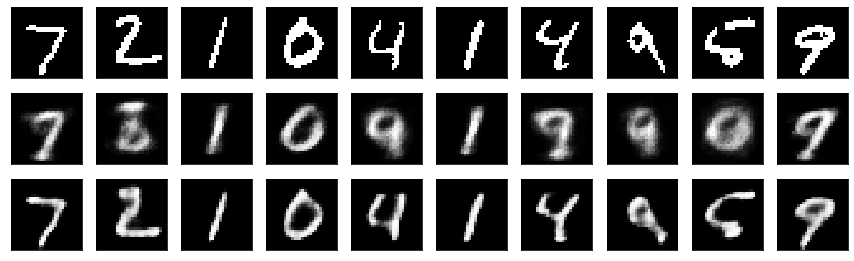

In [28]:
################ mlp / conv autoencoders ##################
n = 10  # how many samples
y_test_mlp = mlp.predict(x_test_flat[:n]).reshape(-1,28,28)
y_test_conv = conv.predict(x_test[:n]).reshape(-1,28,28)

plt.figure(figsize=(15, 4.5))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test_mlp[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(y_test_conv[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

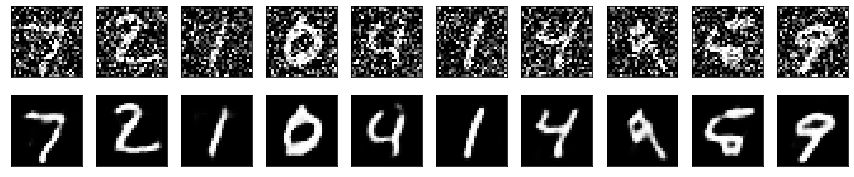

In [33]:
###################### conv denoiser #######################
n = 10
noise_factor = 0.5
x_test_noisy  = np.clip(x_test  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape),  0., 1.)
y_test_conv = denoiser.predict(x_test_noisy[:n]).reshape(-1,28,28)

plt.figure(figsize=(15, 3))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_test_conv[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

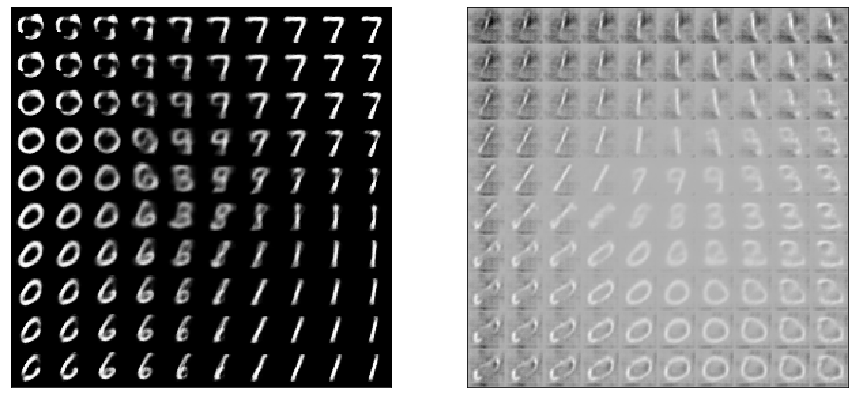

In [71]:
#################### mlp / conv vae ######################
n = 10  # nsample per row/column
digit_size = 28
figmlp = np.zeros((digit_size * n, digit_size * n))
figconv = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        digit = mlpdecoder.predict(z_sample)[0].reshape(digit_size, digit_size)
        figmlp[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        digit = convdecoder.predict(z_sample)[0].reshape(digit_size, digit_size)
        figconv[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 2, 1)
plt.imshow(figmlp)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(figconv)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()